<a href="https://colab.research.google.com/github/shinnew9/cse347-cse447RL/blob/main/lab3_TD_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Temporal Difference Learning

In this lab, we will practice TD Learning methods, including SARSA and Q-Learning. Both are tabular methods that work on finite MDP.

We will solve the cliff problem: https://gymnasium.farama.org/environments/toy_text/cliff_walking/#is_slippy


The following code runs in colab, if you want to see the animation, you have to run it using python locally on your computer and replacing render_mode="ansi" for render_mode="human".

Thef follwing code runs the cliff problem using a random policy.

In [73]:
import gymnasium as gym

# Create the environment
env = gym.make("CliffWalking-v1", render_mode="ansi")

n_episodes = 5      # number of episodes to run
max_steps = 100     # safety cap

for episode in range(n_episodes):
    state, info = env.reset()
    done = False
    total_reward = 0

    for step in range(max_steps):
        # Random policy: sample an action uniformly
        action = env.action_space.sample()

        next_state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        state = next_state

        if terminated or truncated:
            break

    print(f"Episode {episode+1}: total reward = {total_reward}")

env.close()

Episode 1: total reward = -595
Episode 2: total reward = -1189
Episode 3: total reward = -694
Episode 4: total reward = -1090
Episode 5: total reward = -1189


## Exercise 1: SARSA
Implement SARSA to solve the cliff problem above. Recommendations:



1. Define your Q table, as a matrix of [number of states] x [number of actions]
2. Greedy policy: Write a function that receives a state, the Q table, and returns the best action (the one with the maximum Q value).
3. $\epsilon$-greedy: Wreite a function that chooses the greedy policy with $\epsilon$ probality, and chooses a random actions with 1-$\epsilon$ probability.
4. Implement the SARSA algorithm based on the pseudo-code



In [74]:
import gymnasium as gym
import numpy as np
# from collections import default

# Create the environment
env = gym.make("CliffWalking-v1", render_mode="ansi")

n_episodes = 1000      # number of episodes to run
max_steps = 100     # safety cap

# Q-learning parameters
learning_rate = 0.1
discount_factor = 0.99
epsilon = 0.1 # Epsilon for epsilon-greedy policy
rng = np.random.default_rng() # Random number generator

n_actions = env.action_space.n
n_states = env.observation_space.n
Q = np.zeros((n_states, n_actions))


def greedy_action(Q, state):
    """Return argmax_a Q[state, a]."""
    return int(np.argmax(Q[state]))

def epsilon_greedy(Q, state, n_actions, epsilon, rng):
    """With prob ε: random action, else: greedy."""
    if rng.random() < epsilon:
        return int(rng.integers(0, n_actions))
    else:
        return greedy_action(Q, state)


## SARSA Training ##
def SARSA(env, Q, n_episodes, learning_rate, n_actions, n_states, epsilon, rng):
  for episode in range(n_episodes):
    state, info = env.reset()
    terminated = False
    truncated = False
    total_reward = 0
    A = epsilon_greedy(Q, state, n_actions, epsilon, rng)
    while not (terminated or truncated):
      next_state, reward, terminated, truncated, info = env.step(A)
      total_reward += reward
      next_A = epsilon_greedy(Q, next_state, n_actions, epsilon, rng)
      Q[state, A] = Q[state, A] + learning_rate * (reward + discount_factor * Q[next_state, next_A] - Q[state, A])
      state = next_state
      A = next_A
    # print(f"Episode {episode+1}: total reward = {total_reward}")
    # print(f"Episode {episode%100}: total_reward = {total_reward%100}")
  return Q



if __name__ == "__main__":
  Q = SARSA(env, Q, n_episodes, learning_rate, n_actions, n_states, epsilon, rng)
  env.close()


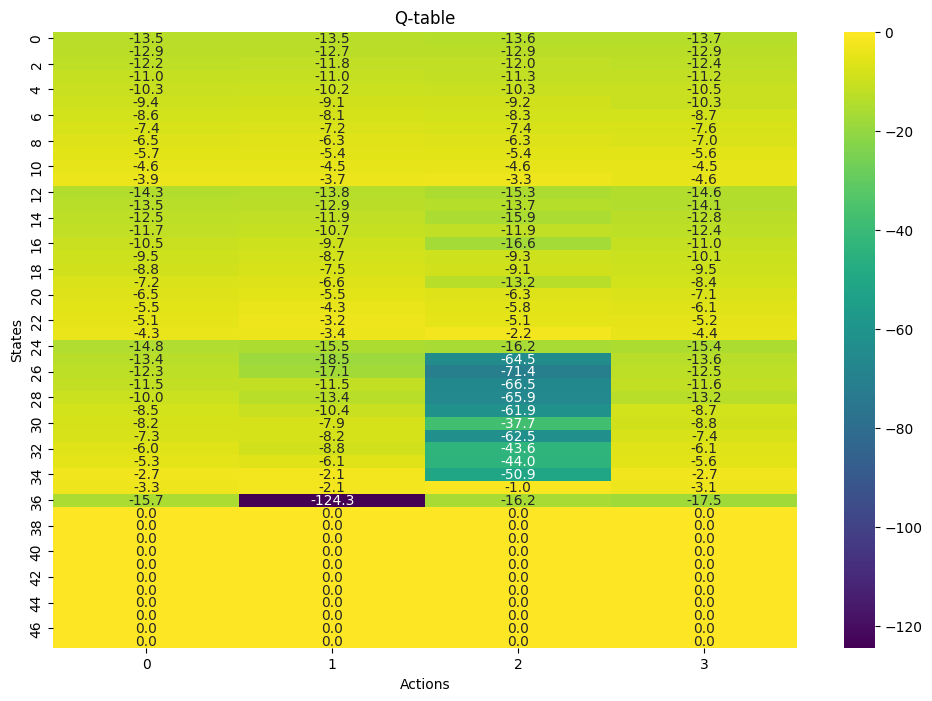

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_Q(Q):
  plt.figure(figsize=(12, 8))
  sns.heatmap(Q, annot=True, fmt=".1f", cmap="viridis")
  plt.xlabel("Actions")
  plt.ylabel("States")
  plt.title("Q-table")
  plt.show()

plot_Q(Q)

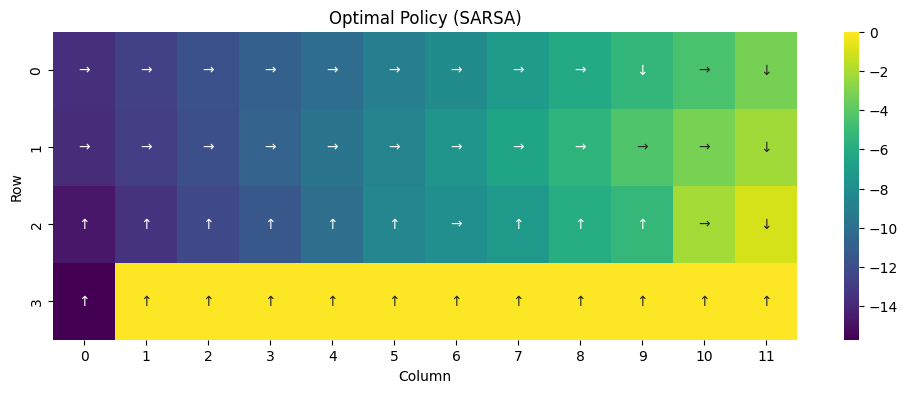

In [76]:
def plot_policy(Q, title="SARSA"):
  # Reshape Q table to a 4x12 grid
  Q_grid = Q.reshape((4, 12, n_actions))

  # Get the optimal action for each state and its corresponding Q-value
  optimal_action = np.argmax(Q_grid, axis=2)
  optimal_policy_Q = np.max(Q_grid, axis=2)


  # Define arrow mapping based on action space (0: up, 1: right, 2: down, 3: left)
  action_arrows = {0: "↑", 1: "→", 2: "↓", 3: "←"}
  optimal_policy_arrows = np.vectorize(action_arrows.get)(optimal_action)


  plt.figure(figsize=(12, 4))
  sns.heatmap(optimal_policy_Q, annot=optimal_policy_arrows, fmt="", cmap="viridis", cbar=True) # Add color bar back
  plt.xlabel("Column")
  plt.ylabel("Row")
  plt.title("Optimal Policy (SARSA)")
  plt.show()
plot_policy(Q)

## Exercise 2.1: Q: Learning
Implement Q-learning method to solve the cliff problem

In [84]:
import gymnasium as gym
import numpy as np
# from collections import default

# Create the environment
env = gym.make("CliffWalking-v1", render_mode="ansi")

n_episodes = 3000      # number of episodes to run
max_steps = 100     # safety cap

# Q-learning parameters
learning_rate = 0.1
discount_factor = 0.99
epsilon = 0.11 # Epsilon for epsilon-greedy policy
rng = np.random.default_rng() # Random number generator

n_actions = env.action_space.n
n_states = env.observation_space.n
Q = np.zeros((n_states, n_actions))


def greedy_action(Q, state):
    """Return argmax_a Q[state, a]."""
    return int(np.argmax(Q[state]))

def epsilon_greedy(Q, state, n_actions, epsilon, rng):
    """With prob ε: random action, else: greedy."""
    if rng.random() < epsilon:
        return int(rng.integers(0, n_actions))
    else:
        return greedy_action(Q, state)

## Q-Learning (updating the maximum Q function from SARSA Training) ##
def q_learning(env, Q, n_episodes, learning_rate, n_actions, n_states, epsilon, rng):
  rewards_list = []
  for episode in range(n_episodes):
    state, info = env.reset()
    terminated = False
    truncated = False
    total_reward = 0
    while not (terminated or truncated):
      A = epsilon_greedy(Q, state, n_actions, epsilon, rng)
      next_state, reward, terminated, truncated, info = env.step(A)
      total_reward += reward
      # Q-Learning update rule: using the maximum Q-value from the next state
      Q[state, A] = Q[state, A] + learning_rate * (reward + discount_factor * np.max(Q[next_state, :]) - Q[state, A])
      state = next_state
    rewards_list.append(total_reward)
    # print(f"Episode {episode+1}: total reward = {total_reward}")
    # print(f"Episode {episode%100}: total_reward = {total_reward%100}")
  return Q, rewards_list



if __name__ == "__main__":
  Q_q_learning, rewards_q_learning = q_learning(env, Q.copy(), n_episodes, learning_rate, n_actions, n_states, epsilon, rng)
  env.close()

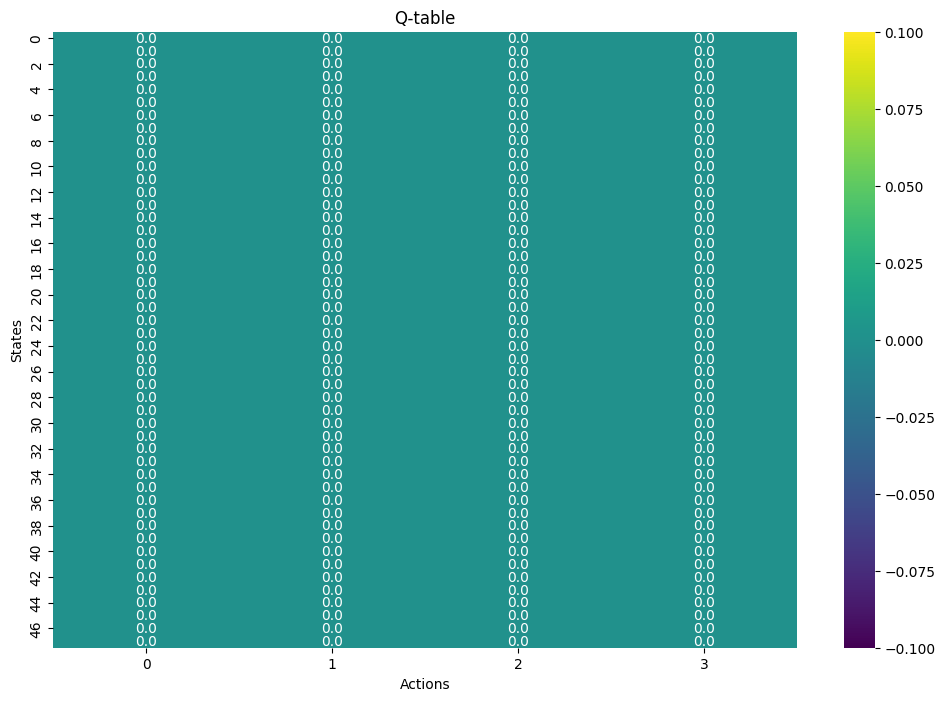

In [82]:
plot_Q(Q)

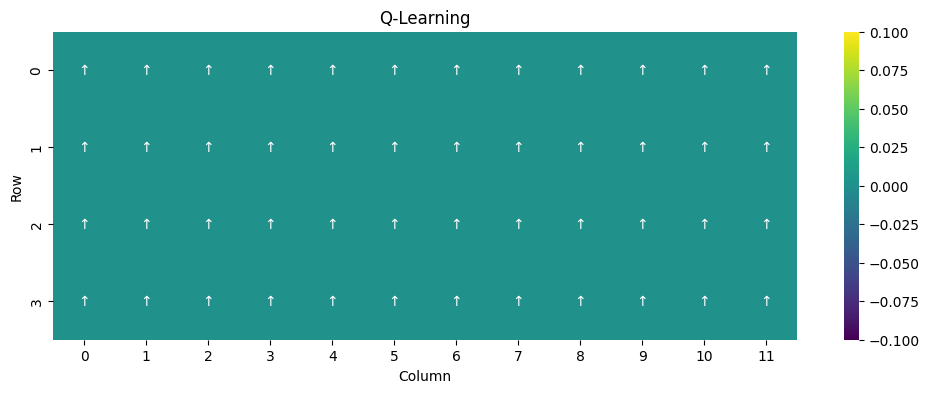

In [83]:
def plot_policy(Q, title="Q-Learning"):
  # Reshape Q table to a 4x12 grid
  Q_grid = Q.reshape((4, 12, n_actions))

  # Get the optimal action for each state and its corresponding Q-value
  optimal_action = np.argmax(Q_grid, axis=2)
  optimal_policy_Q = np.max(Q_grid, axis=2)


  # Define arrow mapping based on action space (0: up, 1: right, 2: down, 3: left)
  action_arrows = {0: "↑", 1: "→", 2: "↓", 3: "←"}
  optimal_policy_arrows = np.vectorize(action_arrows.get)(optimal_action)


  plt.figure(figsize=(12, 4))
  sns.heatmap(optimal_policy_Q, annot=optimal_policy_arrows, fmt="", cmap="viridis", cbar=True) # Add color bar back
  plt.xlabel("Column")
  plt.ylabel("Row")
  plt.title("Q-Learning")
  plt.show()
plot_policy(Q)

## Exercise 2.2: SARSA vs Q-learning
 1. Compare the results betwen SARSA and Q-Learning (plot a graph of the sum of rewards duing each episode for each algorithm).
 2. Include the is_slippery=True parameter. Compare again, which one is better?


In [80]:
Q_sarsa, rewards_sarsa = SARSA(env, np.zeros((n_states, n_actions)), n_episodes, learning_rate, n_actions, n_states, epsilon, rng)
Q_q_learning, rewards_q_learning = q_learning(env, np.zeros((n_states, n_actions)), n_episodes, learning_rate, n_actions, n_states, epsilon, rng)


plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(rewards_sarsa), label="SARSA")
plt.plot(np.cumsum(rewards_q_learning), label="Q-Learning")

plt.xlabel("Episode")
plt.ylabel("Sum of rewards")
plt.title("Comparison of SARSA and Q-Learning")
plt.legend()
plt.show()


# def comparison_plot():

ValueError: too many values to unpack (expected 2)

# Exercise 3 (graduate students): 8x8 grid problem
Solve the 8x8 grid problem from the previous lab. You can use SARSA or Q-learning. How many episodes does it need to learn the optimal policy?
